# Linear regression with regularization
### by Xiaoqi Zheng, 03/18/2020

In [6]:
set.seed(123)    # seed for reproducibility
library(glmnet)  # for lasss/ridge/elastic net regression

Loading required package: Matrix

Loaded glmnet 3.0-2




In [3]:
## load data
data("mtcars")

X <- as.matrix(mtcars[,which(names(mtcars)!="mpg")])
#y <- as.matrix(scale(mtcars[,"mpg"],center = T,scale = T)) # scale y
y <- mtcars[,"mpg"]

In [4]:
## select training and test samples
n <- nrow(X)
train_rows <- sample(1:n, .66*n) ## 66% training, 34% test

X.train <- X[train_rows, ]
X.test <- X[-train_rows, ]

y.train <- y[train_rows]
y.test <- y[-train_rows]


## 1. Lasso 
#### Steps
1. Select best lambda by cross-validation (Optional);
2. Train a model by selected lambda;
3. Prediction


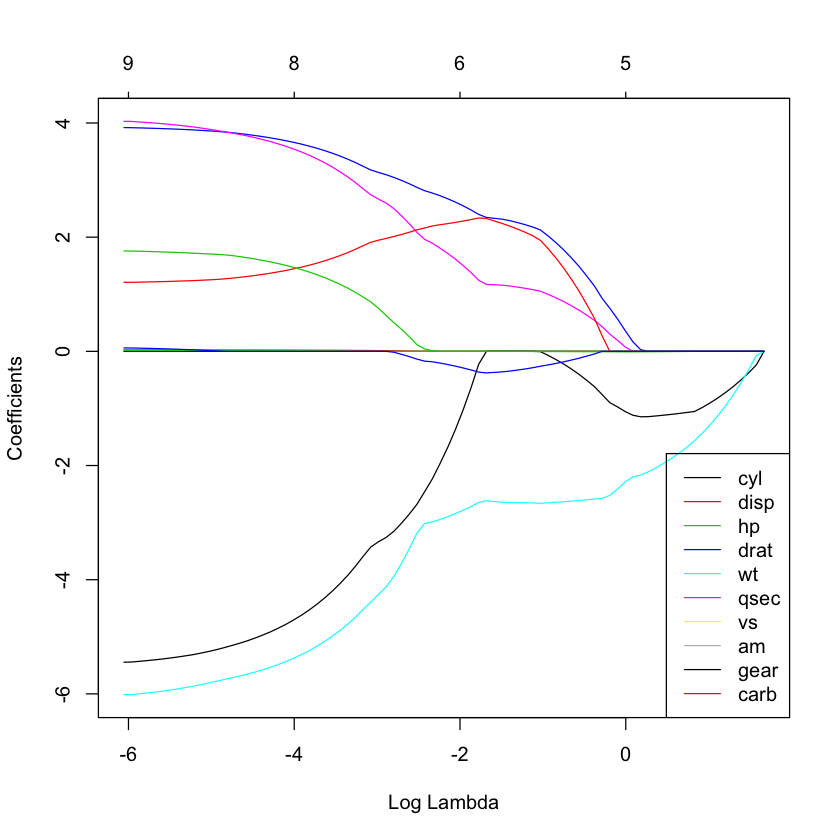

In [7]:
# See how increasing lambda shrinks the coefficients --------------------------
# Setting alpha = 1 implements lasso regression
lasso.model <- glmnet(X.train, y.train, alpha = 1, standardize = TRUE)
plot(lasso.model, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:ncol(X.train), legend = colnames(X), cex = 1)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


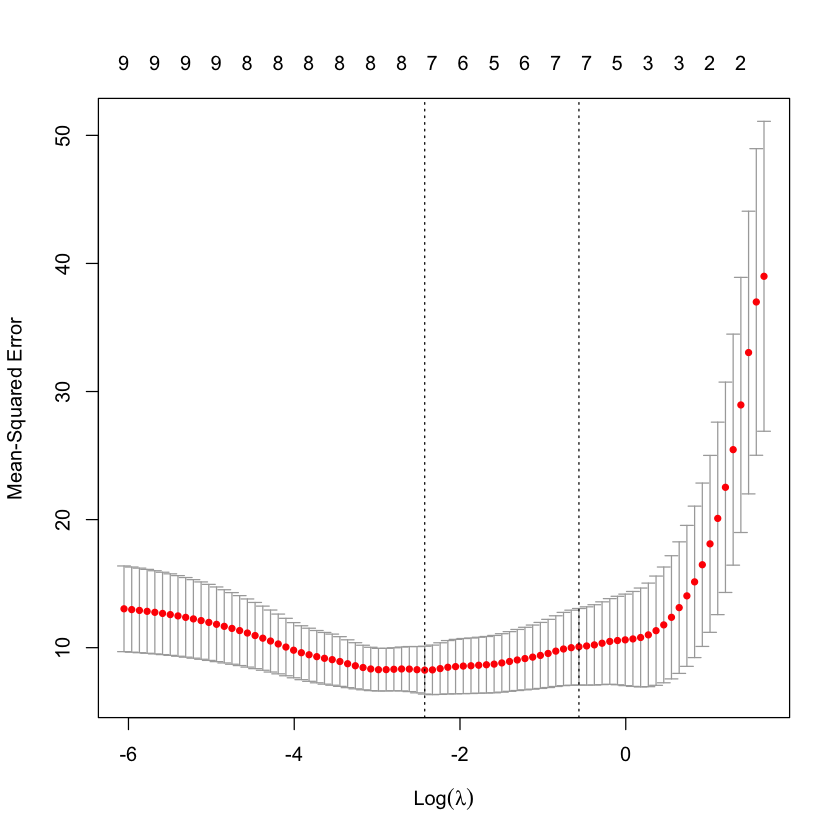

In [8]:
# Perform 10-fold cross-validation to select lambda
lasso_cv <- cv.glmnet(X.train, y.train, alpha = 1, type.measure="mse",
                      standardize = TRUE, nfolds =10,family="gaussian")
# Plot cross-validation results
plot(lasso_cv)

In [9]:
# Select best cross-validated lambda
lambda_cv <- lasso_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
## 注：也有人不做前面的交叉验证步骤，直接给 lambda一个值，比如lambda = 0.001
lasso.model <- glmnet(X.train, y.train, lambda = lambda_cv, alpha = 1, standardize = TRUE)


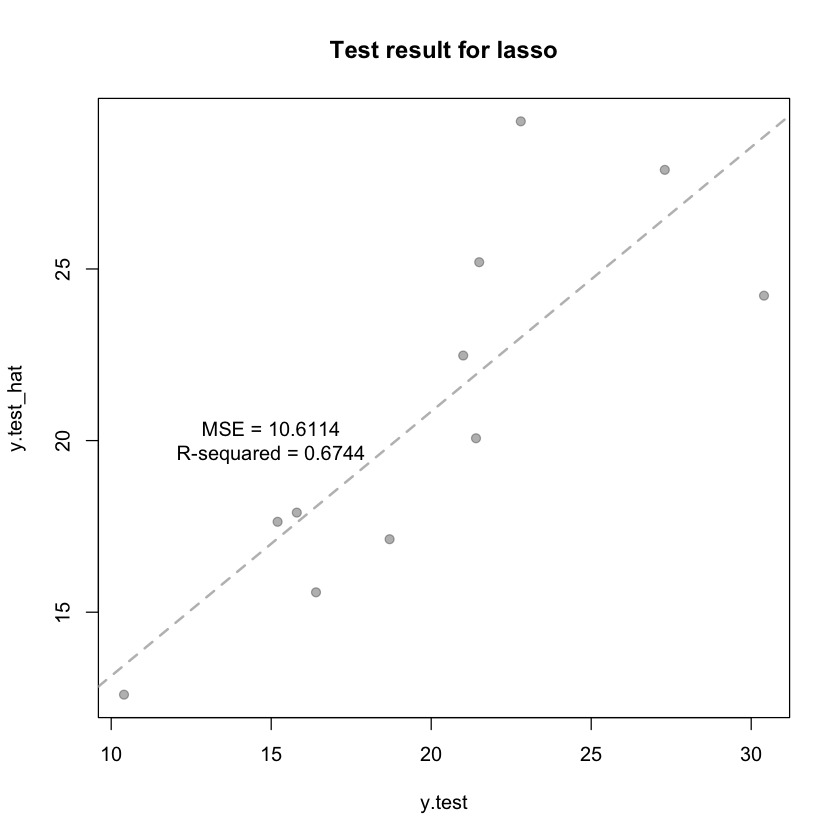

In [11]:
# Make prediction
y.test_hat <- predict(lasso.model, X.test)

Rsquare <- cor(y.test,y.test_hat)^2
MSE <- mean((y.test - y.test_hat)^2)

plot(y.test,y.test_hat,col="#00000050",pch = 19,main = "Test result for lasso")
abline(lm(y.test_hat~y.test),lty = 2,lwd = 2,col = "gray")
text(x = 15,y = 20,labels = paste0("MSE = ",round(MSE,4),"\n","R-sequared = ",round(Rsquare,4)))


## 2. Ridge 

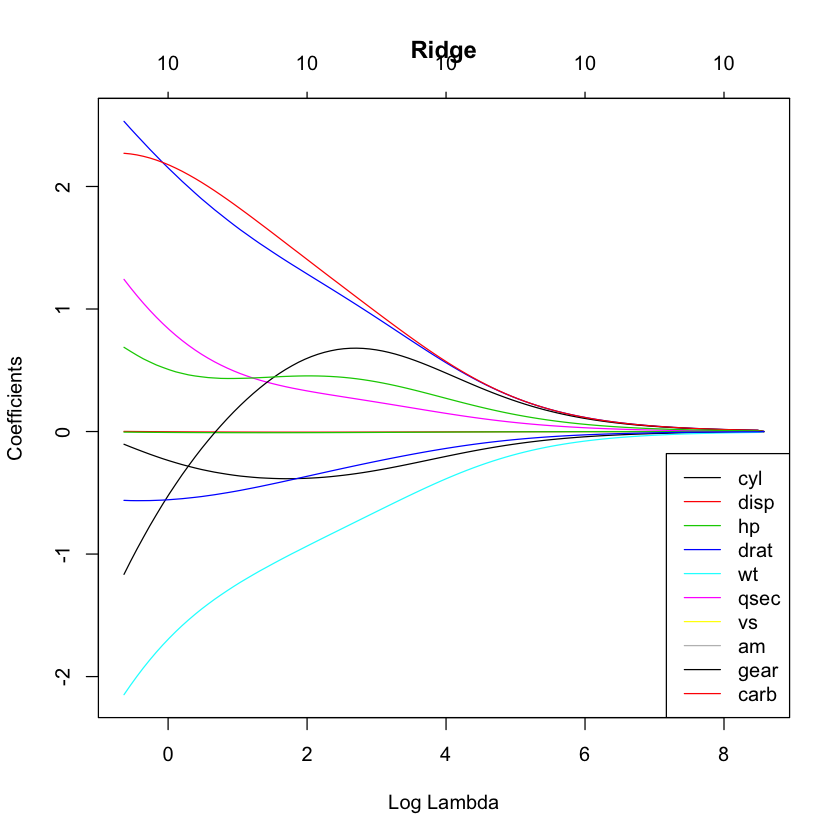

In [12]:
# See how increasing lambda shrinks the coefficients --------------------------
# Setting alpha = 0 implements ridge regression
ridge.model <- glmnet(X.train, y.train, alpha = 0, standardize = TRUE)
plot(ridge.model, xvar = "lambda",main = "Ridge")
legend("bottomright", lwd = 1, col = 1:ncol(X.train), legend = colnames(X), cex = 1)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


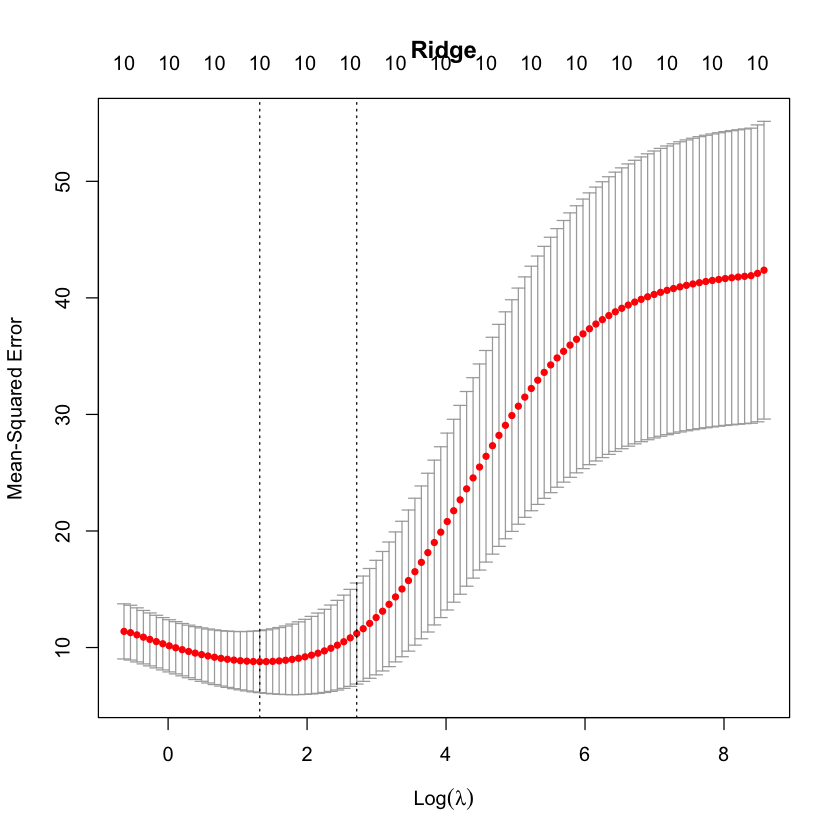

In [13]:
# Perform 10-fold cross-validation to select lambda
ridge_cv <- cv.glmnet(X.train, y.train, alpha = 0, type.measure="mse",
                      standardize = TRUE, nfolds =10,family="gaussian")
# Plot cross-validation results
plot(ridge_cv,main = "Ridge")

In [14]:
# Select best cross-validated lambda
lambda_cv <- ridge_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
## 注：也有人不做前面的交叉验证步骤，直接给 lambda一个值，比如lambda = 0.001
ridge.model <- glmnet(X.train, y.train, lambda = lambda_cv, alpha = 0, standardize = TRUE)

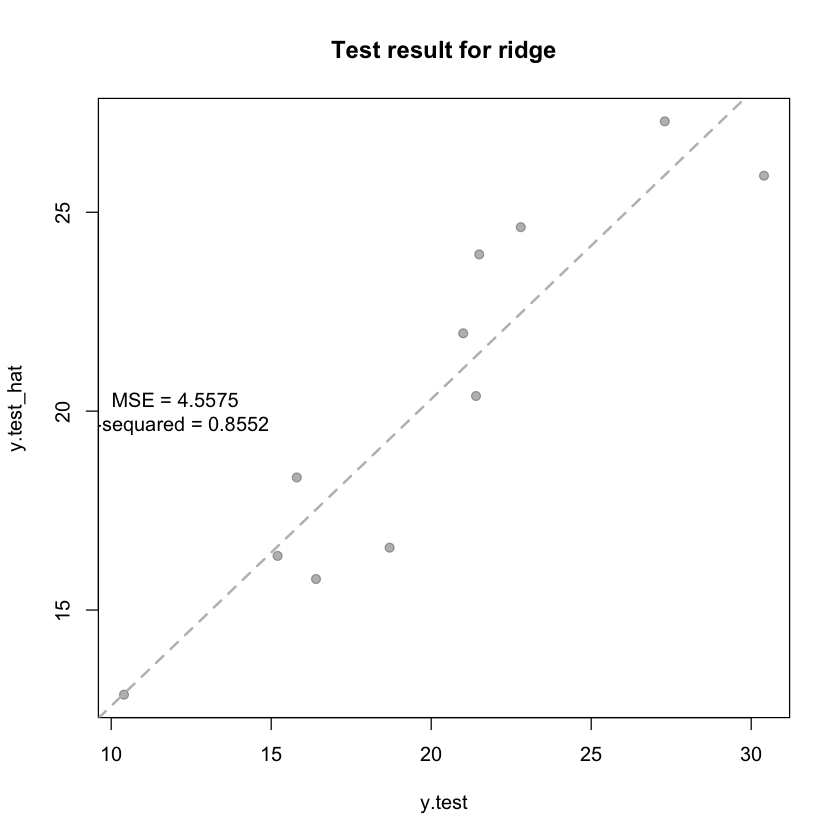

In [15]:
# Make prediction
y.test_hat <- predict(ridge.model, X.test)

Rsquare <- cor(y.test,y.test_hat)^2
MSE <- mean((y.test - y.test_hat)^2)

plot(y.test,y.test_hat,col="#00000050",pch = 19,main = "Test result for ridge")
abline(lm(y.test_hat~y.test),lty = 2,lwd = 2,col = "gray")
text(x = 12,y = 20,labels = paste0("MSE = ",round(MSE,4),"\n","R-sequared = ",round(Rsquare,4)))


## 3. Elastic Net
There are two parameters to tune: λ and α. **The glmnet package allows to tune λ via cross-validation for a fixed α**, but it does not support α-tuning, so we will turn to **caret** for this job.

In [16]:
dat <- cbind(y.train, X.train)
head(dat)

,y.train,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Maserati Bora,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8
Porsche 914-2,26.0,4,120.3,91,4.43,2.140,16.70,0,1,5,2
Fiat 128,32.4,4,78.7,66,4.08,2.200,19.47,1,1,4,1
Merc 280C,17.8,6,167.6,123,3.92,3.440,18.90,1,0,4,4
Pontiac Firebird,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4


In [17]:
library(caret)

# Set training control
train_control <- trainControl(method = "repeatedcv",
                              number = 5,
                              repeats = 5,
                              search = "random",
                              verboseIter = F)

# Train the model
elastic_net_model <- train(y.train ~ .,
                           data = dat,
                           method = "glmnet",
                           preProcess = c("center", "scale"),
                           tuneLength = 25,
                           trControl = train_control)


Loading required package: lattice

Loading required package: ggplot2



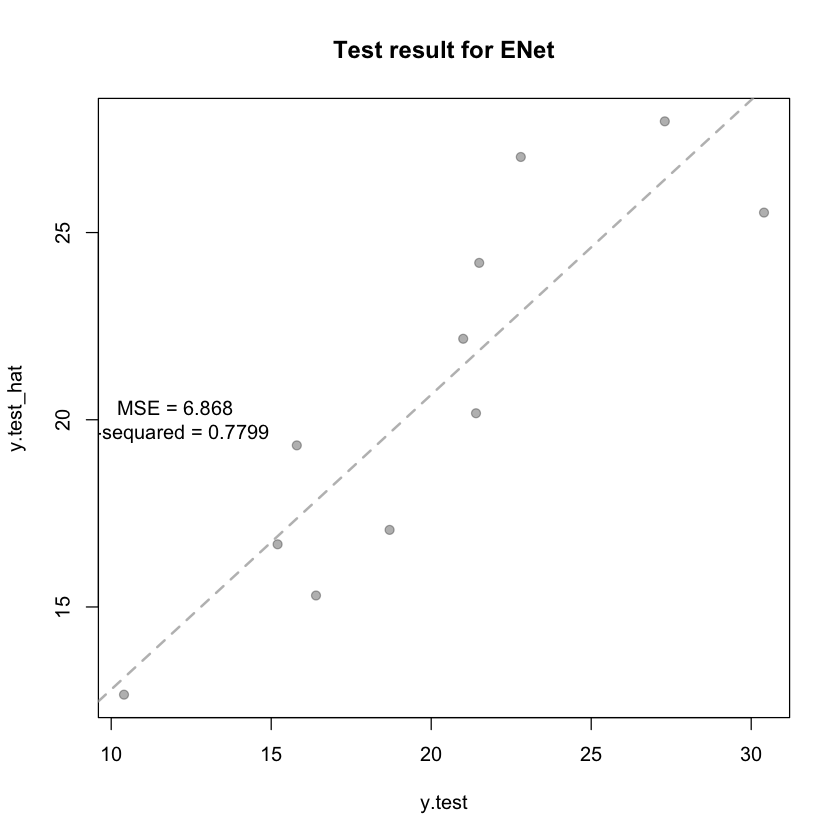

In [18]:
# Check results
y.test_hat <- predict(elastic_net_model, X.test)
Rsquare <- cor(y.test, y.test_hat)^2
MSE <- mean((y.test - y.test_hat)^2)

plot(y.test,y.test_hat,col="#00000050",pch = 19,main = "Test result for ENet")
abline(lm(y.test_hat~y.test),lty = 2,lwd = 2,col = "gray")
text(x = 12,y = 20,labels = paste0("MSE = ",round(MSE,4),"\n","R-sequared = ",round(Rsquare,4)))


